#  Environment Setup

In [1]:
# Install the 'transformers' library from Hugging Face, which includes the SAM model
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Importing Libraries

In [2]:
# Importing necessary libraries
from tensorflow import keras
from transformers import TFSamModel, SamProcessor   # Import SAM model and processor from transformers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image                      # Import Image from PIL for image operations
import requests                            # Import requests to make HTTP requests
import glob                                # Import glob for file path pattern matching
import os

# Model Initialization

In [3]:
# Initialize the SAM model and processor from Hugging Face's transformers
sam_model = TFSamModel.from_pretrained("facebook/sam-vit-huge")
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

# Visualization Functions

In [4]:
# Enable TensorFlow's numpy behavior for compatibility
np_config.enable_numpy_behavior()

# Function to display a mask on an image
def display_mask(mask, ax, random_color=False):
    # Random color for the mask if random_color is True
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else: # Default color
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_img = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_img)

# Function to display a bounding box on an image
def display_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

# Function to display bounding boxes on an image
def display_boxes_on_img(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        display_box(box, plt.gca())
    plt.axis("on")
    plt.show()

# Function to display points on an image
def display_points_on_img(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    display_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()

# Function to display both points and bounding boxes on an image
def display_points_and_boxes_on_img(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    display_points(input_points, labels, plt.gca())
    for box in boxes:
        display_box(box, plt.gca())
    plt.axis("on")
    plt.show()

# Function to display points
def display_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="blue",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )

# Function to display masks on an image
def display_masks_on_img(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        display_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

# Image Loading

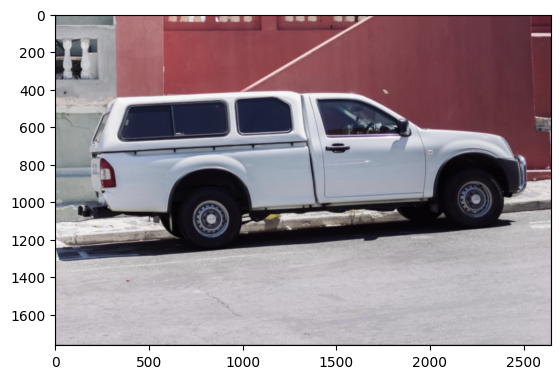

In [5]:
# Load an image from a URL
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
plt.imshow(raw_image)
plt.show()

# Image Preprocessing, and Segmentation

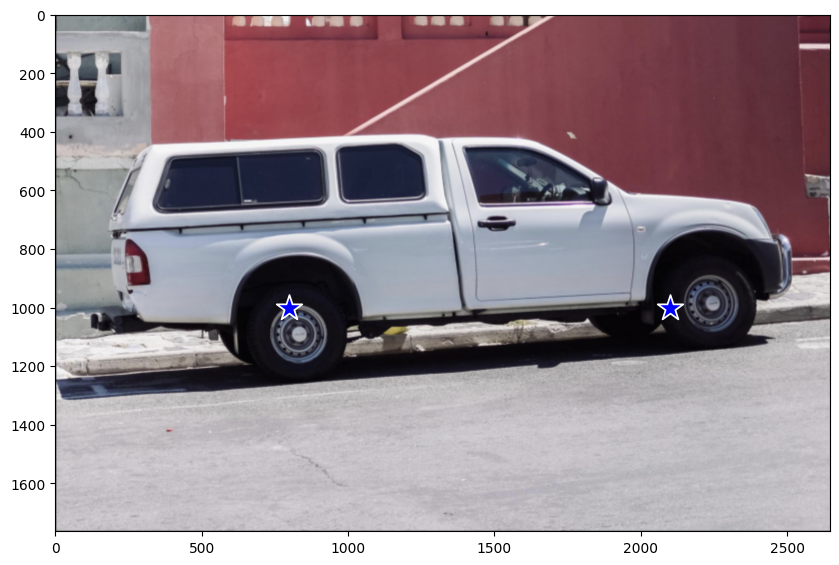

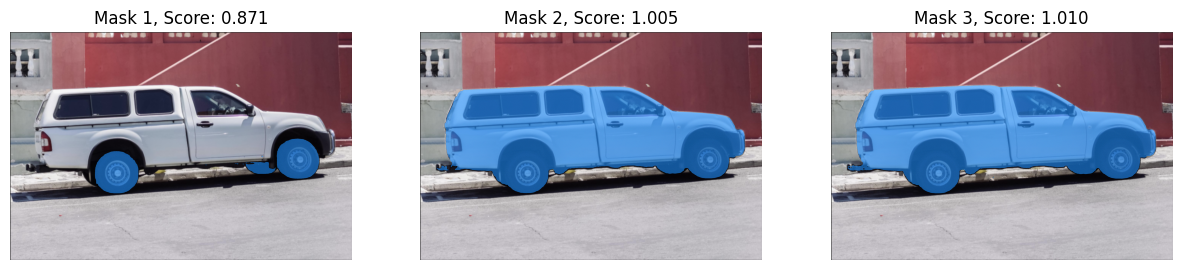

In [6]:
# Define input points for segmentation
input_points = [[[800, 1000], [2100,1000]]]
# Visualize the input points on the image
display_points_on_img(raw_image, input_points[0])

# Preprocess the input image and points for the SAM model
inputs = sam_processor(raw_image, input_points=input_points, return_tensors="tf")

# Perform segmentation with the SAM model
outputs = sam_model(**inputs)

# Post-process the predicted masks for visualization
masks = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"],
    return_tensors="tf",
)

# Display the segmentation masks on the image along with their IOU scores
display_masks_on_img(raw_image, masks, outputs.iou_scores)

# Image Preprocessing, and Segmentation

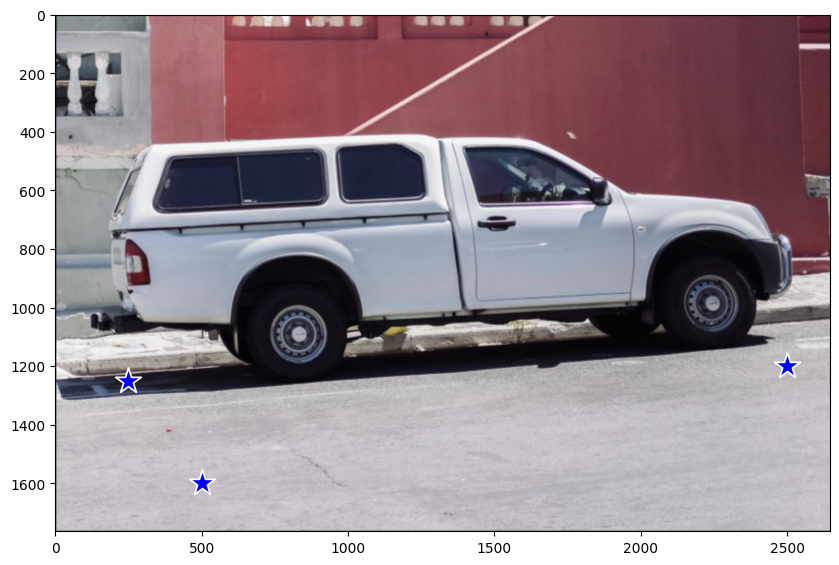

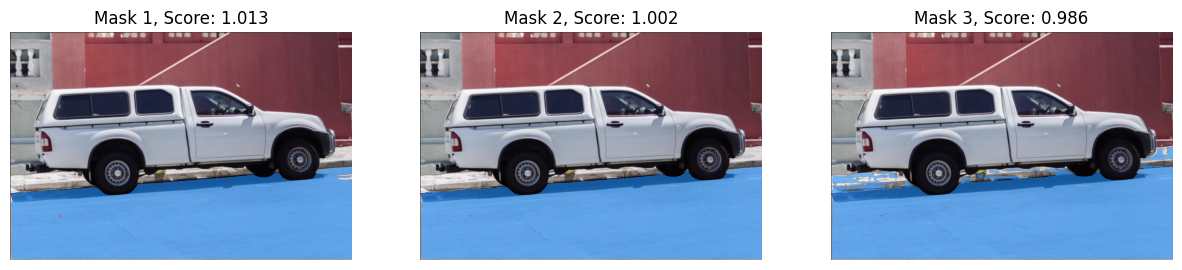

In [7]:
input_points_next = [[[250, 1250], [500,1600], [2500, 1200]]]
# Visualize a single point.
display_points_on_img(raw_image, input_points_next[0])

# Preprocess the input image.
inputs_next = sam_processor(raw_image, input_points=input_points_next, return_tensors="tf")

# Predict for segmentation with the prompt.
outputs_next = sam_model(**inputs_next)

masks = sam_processor.image_processor.post_process_masks(
    outputs_next.pred_masks,
    inputs_next["original_sizes"],
    inputs_next["reshaped_input_sizes"],
    return_tensors="tf",
)

display_masks_on_img(raw_image, masks, outputs_next.iou_scores)

# Fine Tuning SAM

In [9]:
cd "/content/drive/MyDrive/SAM"

/content/drive/MyDrive/SAM


## Dataset Zip File Extraction

In [10]:
!tar -xf breast-cancer-dataset.tar.gz

## Data Preparation

In [28]:
dataset_path = "/content/drive/MyDrive/SAM/breast-cancer-dataset"
# Load all image and label paths from the dataset
image_paths = sorted(glob.glob(os.path.join(dataset_path, "images/*.png")))
label_paths = sorted(glob.glob(os.path.join(dataset_path, "labels/*.png")))

## Data Generator for Model Fine-Tuning

In [29]:
class DataGenerator:
    """Generator class for processing the images and the masks for SAM fine-tuning."""

    def __init__(self, dataset_path, processor, image_paths, label_paths):
        # Initialization of the DataGenerator with dataset path, image and label paths, and the processor
        self.dataset_path = dataset_path
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.processor = processor

    def __call__(self):
        # Generator function to process each image and its corresponding label
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image = np.array(Image.open(image_path))
            ground_truth_mask = np.array(Image.open(label_path))

            # Generate bounding box prompt from the ground truth mask
            prompt = self.get_bounding_box(ground_truth_mask)

            # Prepare the image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="np")

            # Remove the batch dimension added by default by the processor
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # Add the ground truth segmentation mask to the inputs
            inputs["ground_truth_mask"] = ground_truth_mask

            yield inputs

    def get_bounding_box(self, ground_truth_map):
        # Calculate bounding box coordinates from the mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Add perturbation to bounding box coordinates for robustness
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        return bbox


## Training Dataset Creation

In [30]:
# Define the output signature for the TensorFlow dataset
output_signature = {
    "pixel_values": tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    "original_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "reshaped_input_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "input_boxes": tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    "ground_truth_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
}

# Instantiate the DataGenerator with the dataset path and the SAM processor
train_dataset_gen = DataGenerator(dataset_path, sam_processor, image_paths, label_paths)

# Create a TensorFlow dataset from the DataGenerator
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
)


## Training Dataset Configuration

In [31]:
# Set TensorFlow's AUTOTUNE feature for dynamic buffer size adjustment
auto = tf.data.AUTOTUNE

# Define the batch size for training
batch_size = 1

# Define the shuffle buffer size
shuffle_buffer = 4

# Configure the training dataset
train_ds = (
    train_ds.cache()              # Cache the dataset for improved performance
    .shuffle(shuffle_buffer)      # Shuffle the dataset with the defined buffer size
    .batch(batch_size)            # Group the data into batches
    .prefetch(buffer_size=auto)   # Prefetch batches for efficient data loading
)


## Sample Data Inspection

In [32]:
# Retrieve a sample from the training dataset
sample = next(iter(train_ds))

# Iterate over each key in the sample to print its details
for k in sample:
    # Print key name, shape, data type, and check if it's a TensorFlow tensor
    print(k, sample[k].shape, sample[k].dtype, isinstance(sample[k], tf.Tensor))


pixel_values (1, 3, 1024, 1024) <dtype: 'float32'> True
original_sizes (1, 2) <dtype: 'int64'> True
reshaped_input_sizes (1, 2) <dtype: 'int64'> True
input_boxes (1, 1, 4) <dtype: 'float64'> True
ground_truth_mask (1, 256, 256) <dtype: 'int32'> True


## DICE Loss Function Implementation

In [33]:
def dice_loss_func(y_true, y_pred, smooth=1e-5):
    # Apply sigmoid activation to predictions
    y_pred = tf.sigmoid(y_pred)

    # Define axes for reduction based on y_pred dimensions
    reduce_axis = list(range(2, len(y_pred.shape)))

    if batch_size > 1:
        # Include batch dimension in reduction for batch sizes greater than 1
        reduce_axis = [0] + reduce_axis

    # Calculate the intersection
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)

    # Square the true and predicted values
    y_true_sq = tf.math.pow(y_true, 2)
    y_pred_sq = tf.math.pow(y_pred, 2)

    # Sum the squared values
    ground_o = tf.reduce_sum(y_true_sq, axis=reduce_axis)
    pred_o = tf.reduce_sum(y_pred_sq, axis=reduce_axis)

    # Calculate the denominator
    denominator = ground_o + pred_o

    # Calculate the DICE coefficient
    loss = 1.0 - (2.0 * intersection + smooth) / (denominator + smooth)
    # Reduce mean for batch loss
    loss = tf.reduce_mean(loss)

    return loss


## Model Initialization, Training Step Function

In [34]:
# Initialize the SAM model and the optimizer
sam = TFSamModel.from_pretrained("facebook/sam-vit-large")
opt = keras.optimizers.Adam(1e-5)

# Set specific layers of the SAM model to non-trainable
for layer in sam.layers:
    if layer.name in ["vision_encoder", "prompt_encoder"]:
        layer.trainable = False


# Define the training step function
@tf.function
def train_step_func(inputs):
    with tf.GradientTape() as tape:
        # Pass inputs to the SAM model
        outputs = sam(
            pixel_values=inputs["pixel_values"],
            input_boxes=inputs["input_boxes"],
            multimask_output=False,
            training=True,
        )

        # Process the predicted masks and ground truth masks
        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)

        # Calculate the DICE loss
        loss = dice_loss_func(tf.expand_dims(ground_truth_masks, 1), predicted_masks)

        # Update the trainable variables using gradients
        trainable_vars = sam.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        opt.apply_gradients(zip(grads, trainable_vars))

        return loss


All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


## Model Training

In [35]:
# Run the training loop for a specified number of epochs
for epoch in range(5):
    for inputs in train_ds:
        # Perform a training step and calculate the loss
        loss = train_step_func(inputs)
    # Print the loss at the end of each epoch
    print(f"Epoch {epoch + 1}: Training Loss = {loss}")

Epoch 1: Training Loss = 0.06427037715911865
Epoch 2: Training Loss = 0.157309889793396
Epoch 3: Training Loss = 0.04870200157165527
Epoch 4: Training Loss = 0.12003147602081299
Epoch 5: Training Loss = 0.04364192485809326


## Inference

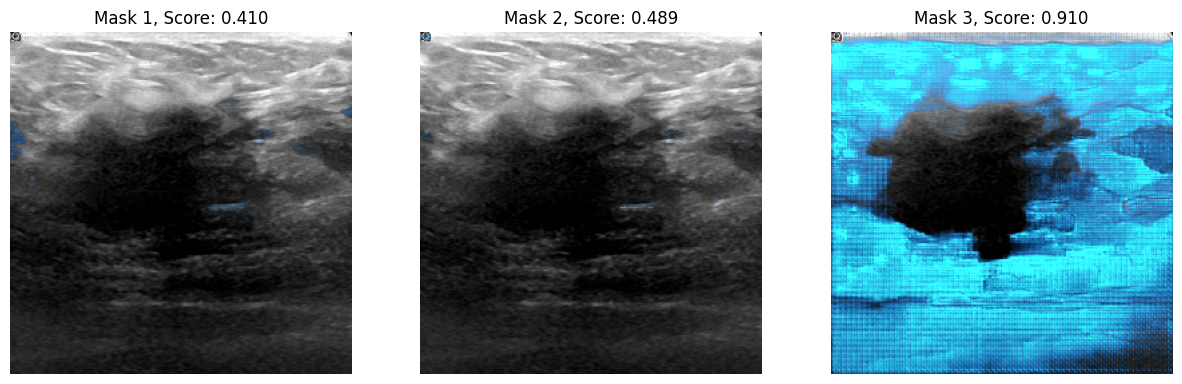

In [42]:
# Load another image for inference
idx = 129  # Specify the index of the image to be used for inference
raw_img_inference = Image.open(image_paths[idx])  # Load the image from the dataset

# Process the image using the SAM processor
preprocessed_img = sam_processor(raw_img_inference)

# Perform inference using the SAM model
outputs = sam(preprocessed_img)

# Extract the predicted masks and IoU scores from the outputs
infer_masks = outputs["pred_masks"]
iou_scores = outputs["iou_scores"]

# Display the predicted masks and IoU scores on the image
display_masks_on_img(raw_img_inference, masks=infer_masks, scores=iou_scores)